<a href="https://colab.research.google.com/github/raulbenitez/ZUMAIN_course/blob/main/MNIST_Eigenfaces_vs_deepfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Traditional Machine Learning approach: eigenfaces

Use PCA to extract features from the images and a simple supervised classifier to classify them according to classes

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


PCA to explain 95% of the variance in the training set:

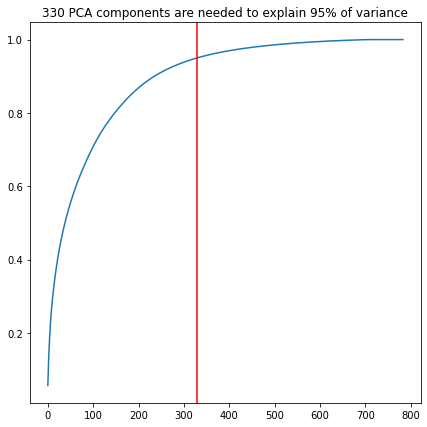

The PCA training set has dimensions 60000 330


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# Reshape as NOBSERVATIONS x NPIXELS:
train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])


# Scale (Standardization)
train = StandardScaler().fit_transform(train)
test = StandardScaler().fit_transform(test)

pca_full = PCA(n_components=test.shape[1])
pca_full.fit(train)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(7,7))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

# GET PCA FEATURES PROJECTING TO THE PCA SPACE:
pca95 = PCA(n_components=Ncomponents_95)
pca_train = pca95.fit_transform(train)
pca_test = pca95.fit_transform(test)

print('The PCA training set has dimensions {} {}'.format(*pca_train.shape))

## Visualize PCA features of the test subset using t-SNE


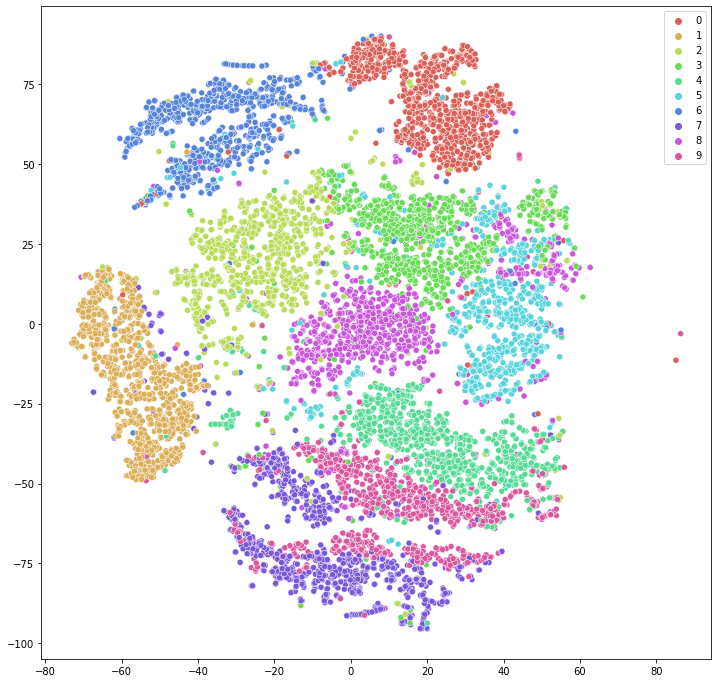

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0)
tsne_pca = tsne.fit_transform(pca_test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

## Fit a kNN classifier using PCA features

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2) # load the model
knn.fit(pca_train,y_train) # fit the model using training data 
y_test_pred = knn.predict(pca_test) # model prediction of test data

In [ ]:
print(confusion_matrix(y_test, y_test_pred))

[[ 747   11    9   52   30   64   15    4   21   27]
 [  12 1093    2    3   11    6    2    1    2    3]
 [ 126  155  295   57  179   20   99    9   78   14]
 [ 103  120  108  403   14  105    9    7  139    2]
 [  36   47   25   21  558   12   11   69   71  132]
 [  71  101   54  203   47  192   10   87  108   19]
 [ 144   30   56   12   91   39  569    4   10    3]
 [   4  136   41  103  123   15    1  482   33   90]
 [  48   42   66  314  123   58    5   36  191   91]
 [  12   22   30   19  416   74    1  224   32  179]]


In [ ]:
from sklearn.metrics import classification_report

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.57      0.76      0.65       980
         one       0.62      0.96      0.76      1135
         two       0.43      0.29      0.34      1032
       three       0.34      0.40      0.37      1010
        four       0.35      0.57      0.43       982
        five       0.33      0.22      0.26       892
         six       0.79      0.59      0.68       958
       seven       0.52      0.47      0.49      1028
       eight       0.28      0.20      0.23       974
        nine       0.32      0.18      0.23      1009

    accuracy                           0.47     10000
   macro avg       0.46      0.46      0.44     10000
weighted avg       0.46      0.47      0.45     10000



# Classification using Deep Features

Use a pre-trained CNN architecture to extract deep features

## Pre-processing MNIST data to be used with a pre-trained CNN architecture

Convert training and test subsets in 3-channel images

In [ ]:
x_train3 = np.dstack([train] * 3)
x_test3 = np.dstack([test]*3)
x_train3.shape,x_test3.shape

((60000, 784, 3), (10000, 784, 3))

Reshape images images in tensor format required by tensorflow

In [ ]:
# Reshape images as per the tensor format required by tensorflow
train_X = x_train3.reshape(-1, 28,28,3)
test_X= x_test3.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Resize the images 48*48 as required by VGG16 architecture

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

Normalise the data and change data type to float


In [ ]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

Preprocess the input 


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_X = preprocess_input(train_X)
test_X  = preprocess_input(test_X)

Instantiate the VGG16 model pre-trained with imagenet database. We load only the layers corresponding to the feature extraction and skip the last fully connected layers for classification (include_top=False). 


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

# Parameters:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

# model:
model = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

Extract deep features:

In [ ]:
# Extracting features
train_deep_features = model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_deep_features = model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
train_deep_features.shape,test_deep_features.shape

625/625 [==============================] - 133s 212ms/step


((60000, 1, 1, 512), (10000, 1, 1, 512))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.savez("/content/drive/MyDrive/train_feat", train_deep_features, train_X)
np.savez("/content/drive/MyDrive/test_feat", test_deep_features, test_X)

## Visualize deep features using t-SNE

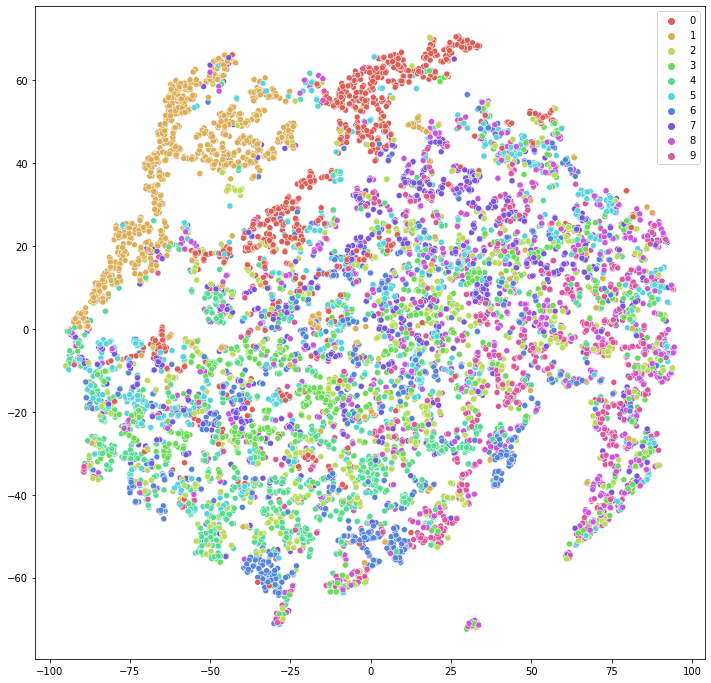

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0)
tsne_deep = tsne.fit_transform(test_deep_features.squeeze())

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_deep[:,0], y = tsne_deep[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

## Classify with deep features

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=2) # load the model
knn.fit(train_deep_features.squeeze(),y_train) # fit the model using training data 
y_test_pred = knn.predict(test_deep_features.squeeze()) # model prediction of test data

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.66      0.86      0.75       980
         one       0.71      0.96      0.82      1135
         two       0.38      0.49      0.43      1032
       three       0.45      0.49      0.47      1010
        four       0.60      0.70      0.64       982
        five       0.43      0.43      0.43       892
         six       0.65      0.52      0.57       958
       seven       0.58      0.61      0.60      1028
       eight       0.54      0.23      0.32       974
        nine       0.77      0.36      0.49      1009

    accuracy                           0.57     10000
   macro avg       0.58      0.56      0.55     10000
weighted avg       0.58      0.57      0.56     10000



We see that the overall accuracy of the classifier improves when using deep features instead PCA features

## The full DL approach

Both feature extraction and classification are performed using a CNN architecture

In [ ]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

train_features_flat = np.reshape(train_deep_features, (60000, 1*1*512))
test_features_flat = np.reshape(test_deep_features, (10000, 1*1*512))


# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])



# Train the the model
history = model.fit(train_features_flat,y_train, epochs=NB_EPOCHS)



Epoch 1/100


ValueError: ignored

In [ ]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()